In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from specutils import Spectrum1D
from astropy import units as u
from specutils.fitting import fit_continuum
from astropy.modeling import models
from astroquery.sdss import SDSS
from astropy import coordinates as coords
from astropy.constants import c
from astroquery.ipac.ned import Ned
from astropy.coordinates import SkyCoord
from astropy.cosmology import Planck18 as cosmo

In [33]:
def download_spectrum(ra, dec, radius):
    co = coords.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')
    xid = SDSS.query_region(co, radius=radius, spectro=True)
    
    if xid is None or len(xid) == 0:
        print("No spectra found in the specified region.")
        return

    plate = xid[0]['plate']
    mjd = xid[0]['mjd']
    fiberID = xid[0]['fiberID']

    sp = SDSS.get_spectra(plate=plate, mjd=mjd, fiberID=fiberID)

    sp[0].writeto('../data/spectra/sell2.fits', overwrite=True)
    print(f"Spectrum saved to ../data/spectra/sell2.fits")


ra = 239.546976
dec =  39.955760
radius = 2.0 * u.arcmin
download_spectrum(ra, dec, radius)

Spectrum saved to ../data/spectra/sell2.fits


Wavelength range: 3794.0224609375 Angstrom - 9189.671875 Angstrom


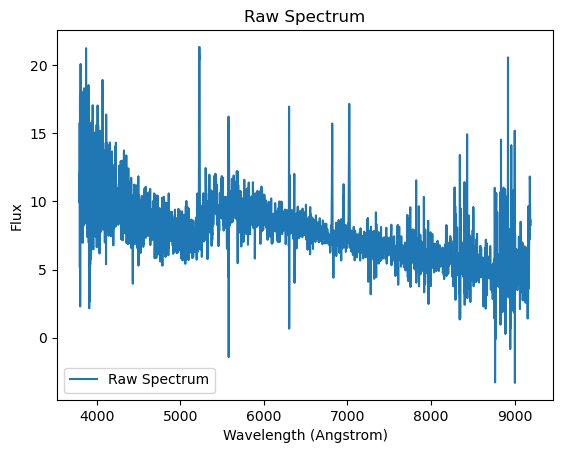

In [2]:
def load_and_inspect_spectrum(filepath):
    hdulist = fits.open(filepath)
    flux = hdulist[1].data['flux'] * u.Unit('1e-17 erg / (s cm^2 Angstrom)')
    wavelength = 10**hdulist[1].data['loglam'] * u.Angstrom
    spectrum = Spectrum1D(flux=flux, spectral_axis=wavelength)

    print(f"Wavelength range: {wavelength.min()} - {wavelength.max()}")

    plt.figure()
    plt.plot(wavelength, flux, label='Raw Spectrum')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Flux')
    plt.title('Raw Spectrum')
    plt.legend()
    plt.show()
    
    return wavelength, spectrum

filepath = '../data/spectra/sell2.fits'
wavelength, raw_spectrum = load_and_inspect_spectrum(filepath)



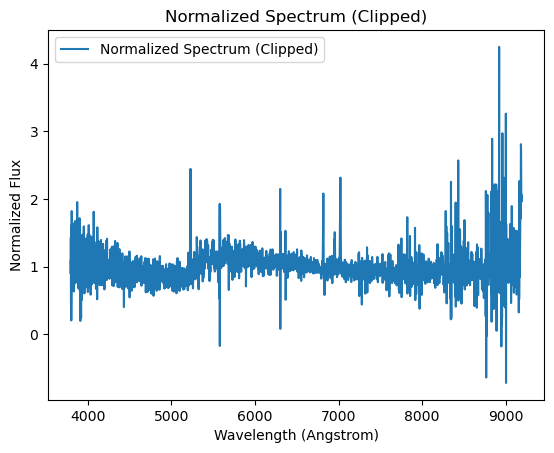

In [3]:
def load_and_normalize_spectrum(filepath, clip_value=60):
    hdulist = fits.open(filepath)
    flux = hdulist[1].data['flux'] * u.Unit('1e-17 erg / (s cm^2 Angstrom)')
    wavelength = 10**hdulist[1].data['loglam'] * u.Angstrom
    spectrum = Spectrum1D(flux=flux, spectral_axis=wavelength)

    polynomial_model = models.Polynomial1D(degree=3)
    continuum_fit = fit_continuum(spectrum, model=polynomial_model)
    normalized_spectrum = spectrum / continuum_fit(spectrum.spectral_axis)

    clipped_flux = np.clip(normalized_spectrum.flux, a_min=-clip_value, a_max=clip_value)
    
    clipped_normalized_spectrum = Spectrum1D(flux=clipped_flux, spectral_axis=wavelength)

    plt.figure()
    plt.plot(spectrum.spectral_axis, clipped_normalized_spectrum.flux, label='Normalized Spectrum (Clipped)')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Normalized Flux')
    plt.title('Normalized Spectrum (Clipped)')
    plt.legend()
    plt.show()
    
    return spectrum.spectral_axis, clipped_normalized_spectrum

filepath = '../data/spectra/sell2.fits'
wavelength, normalized_spectrum = load_and_normalize_spectrum(filepath)


In [4]:
def get_redshift(ra, dec, radius=2.0*u.arcmin):
    co = coords.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')

    xid = SDSS.query_region(co, radius=radius, spectro=True)
    if xid is None or len(xid) == 0:
        print("No data found in the specified region.")
        return None

    redshift = xid[0]['z']
    return redshift

ra = 239.546976
dec =  39.955760
redshift = get_redshift(ra, dec)
print(f"Redshift (z) of the object: {redshift}")


Redshift (z) of the object: 0.4018661


Expected wavelength for Mg II 2796 Å line: 3919.62 Angstrom
Expected wavelength for Mg II 2803 Å line: 3929.43 Angstrom


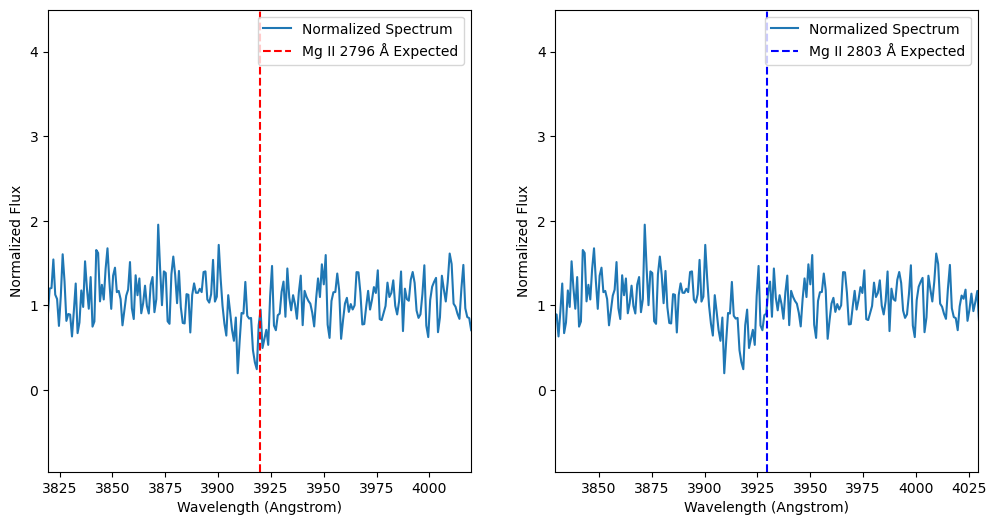

In [5]:
mgii_2796_expected = 2796 * u.Angstrom * (1 + redshift)
mgii_2803_expected = 2803 * u.Angstrom * (1 + redshift)

def plot_expected_mgii_lines(wavelength, normalized_spectrum, redshift):
    
    print(f"Expected wavelength for Mg II 2796 Å line: {mgii_2796_expected:.2f}")
    print(f"Expected wavelength for Mg II 2803 Å line: {mgii_2803_expected:.2f}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(wavelength, normalized_spectrum.flux, label='Normalized Spectrum')
plt.axvline(x=mgii_2796_expected.value, color='r', linestyle='--', label='Mg II 2796 Å Expected')
plt.xlim(mgii_2796_expected.value - 100, mgii_2796_expected.value + 100)  
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Normalized Flux')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(wavelength, normalized_spectrum.flux, label='Normalized Spectrum')
plt.axvline(x=mgii_2803_expected.value, color='b', linestyle='--', label='Mg II 2803 Å Expected')
plt.xlim(mgii_2803_expected.value - 100, mgii_2803_expected.value + 100) 
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Normalized Flux')
plt.legend()
plot_expected_mgii_lines(wavelength, normalized_spectrum, redshift)


Expected wavelength for Mg II 2796 Å line: 3919.62 Angstrom
Observed wavelength for Mg II 2796 Å line: 3909.40 Angstrom
Velocity shift for Mg II 2796 Å line: -781.50 km/s
Expected wavelength for Mg II 2803 Å line: 3929.43 Angstrom
Observed wavelength for Mg II 2803 Å line: 3918.30 Angstrom
Velocity shift for Mg II 2803 Å line: -849.21 km/s


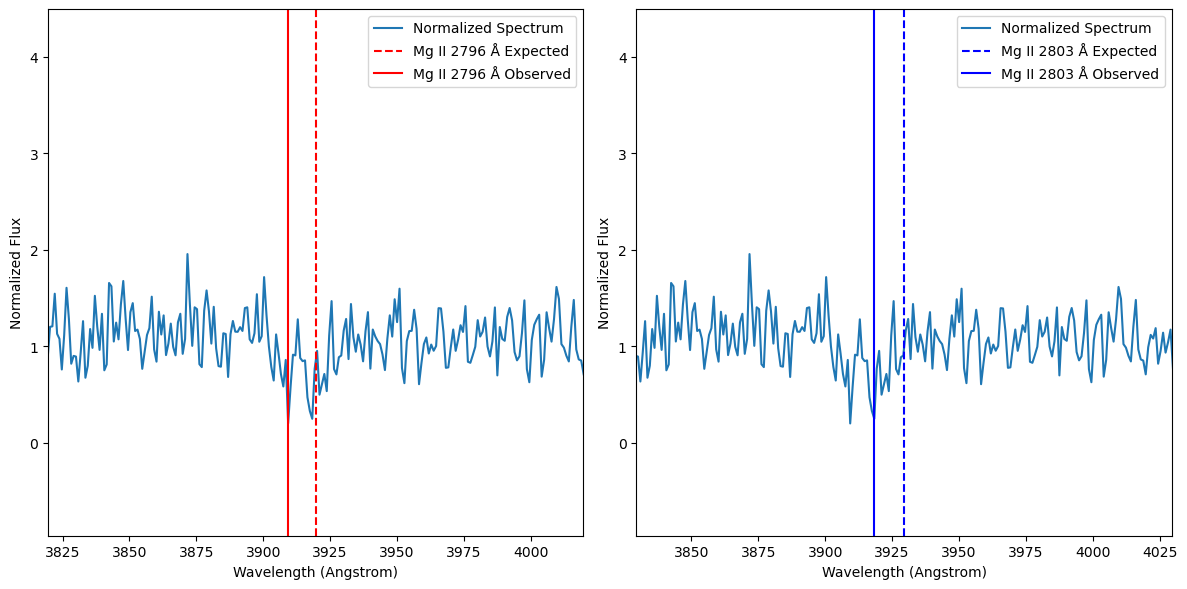

In [6]:
observed_2796 = 3909.4 * u.Angstrom
observed_2803 = 3918.3 * u.Angstrom

def calculate_velocity_shift(observed_wavelength, expected_wavelength):
    velocity = c.to('km/s').value * (observed_wavelength - expected_wavelength) / expected_wavelength
    return velocity

mgii_2796_expected = 2796 * u.Angstrom * (1 + redshift)
mgii_2803_expected = 2803 * u.Angstrom * (1 + redshift)

velocity_shift_2796 = calculate_velocity_shift(observed_2796, mgii_2796_expected)
velocity_shift_2803 = calculate_velocity_shift(observed_2803, mgii_2803_expected)

print(f"Expected wavelength for Mg II 2796 Å line: {mgii_2796_expected:.2f}")
print(f"Observed wavelength for Mg II 2796 Å line: {observed_2796:.2f}")
print(f"Velocity shift for Mg II 2796 Å line: {velocity_shift_2796:.2f} km/s")

print(f"Expected wavelength for Mg II 2803 Å line: {mgii_2803_expected:.2f}")
print(f"Observed wavelength for Mg II 2803 Å line: {observed_2803:.2f}")
print(f"Velocity shift for Mg II 2803 Å line: {velocity_shift_2803:.2f} km/s")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(wavelength, normalized_spectrum.flux, label='Normalized Spectrum')
plt.axvline(x=mgii_2796_expected.value, color='r', linestyle='--', label='Mg II 2796 Å Expected')
plt.axvline(x=observed_2796.value, color='r', linestyle='-', label='Mg II 2796 Å Observed')
plt.xlim(mgii_2796_expected.value - 100, mgii_2796_expected.value + 100)  
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Normalized Flux')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(wavelength, normalized_spectrum.flux, label='Normalized Spectrum')
plt.axvline(x=mgii_2803_expected.value, color='b', linestyle='--', label='Mg II 2803 Å Expected')
plt.axvline(x=observed_2803.value, color='b', linestyle='-', label='Mg II 2803 Å Observed')
plt.xlim(mgii_2803_expected.value - 100, mgii_2803_expected.value + 100) 
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Normalized Flux')
plt.legend()

plt.tight_layout()
plt.show()


Expected wavelength for O II 3726 Å line: 5223.35 Angstrom
Expected wavelength for O II 3729 Å line: 5227.56 Angstrom


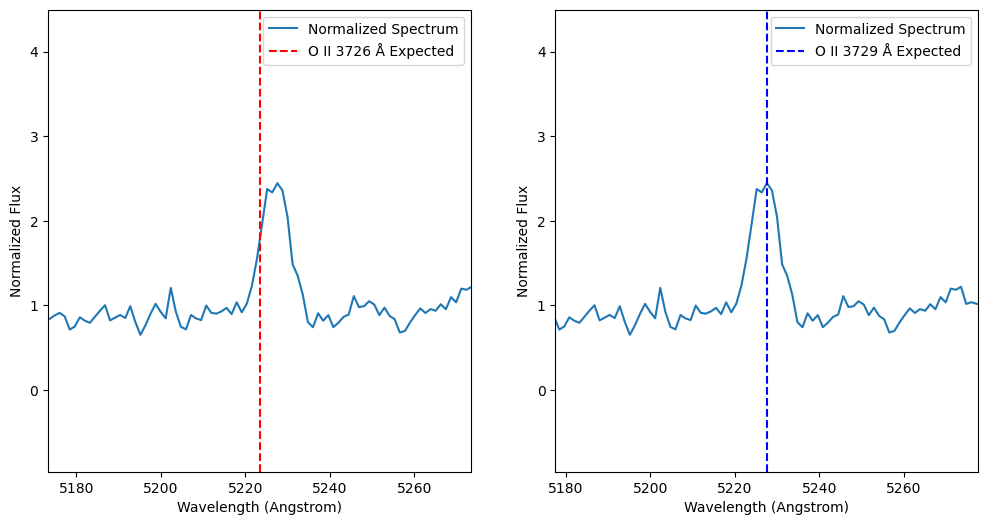

In [7]:
oii_3726_expected = 3726 * u.Angstrom * (1 + redshift)
oii_3729_expected = 3729 * u.Angstrom * (1 + redshift)

def plot_expected_mgii_lines(wavelength, normalized_spectrum, redshift):
    
    print(f"Expected wavelength for O II 3726 Å line: {oii_3726_expected:.2f}")
    print(f"Expected wavelength for O II 3729 Å line: {oii_3729_expected:.2f}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(wavelength, normalized_spectrum.flux, label='Normalized Spectrum')
plt.axvline(x=oii_3726_expected.value, color='r', linestyle='--', label='O II 3726 Å Expected')
plt.xlim(oii_3726_expected.value - 50, oii_3726_expected.value + 50)  
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Normalized Flux')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(wavelength, normalized_spectrum.flux, label='Normalized Spectrum')
plt.axvline(x=oii_3729_expected.value, color='b', linestyle='--', label='O II 3729 Å Expected')
plt.xlim(oii_3729_expected.value - 50, oii_3729_expected.value + 50) 
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Normalized Flux')
plt.legend()
plot_expected_mgii_lines(wavelength, normalized_spectrum, redshift)


In [8]:
def find_nearby_quasars_via_ned_layered(ra, dec, radius=10.0):
    combined_results = []

    print(f"Querying NED with radius: {radius} arcminutes")
    galaxy_coord = SkyCoord(ra=ra, dec=dec, unit=(u.deg, u.deg), frame='icrs')
    try:
        central_result = Ned.query_region(galaxy_coord, radius=radius * u.arcmin, equinox='J2000.0')
        if central_result is not None and len(central_result) > 0:
            combined_results.extend(central_result)
    except Exception as e:
        print(f"Error during NED query: {e}")

    if not combined_results:
        print("No objects found near this galaxy in NED.")
        return [], [], [], []

    filtered_results = []
    ra_list = []
    dec_list = []
    quasar_redshift_list = [] 
    for obj in combined_results:
        try:
            obj_redshift = float(obj['Redshift'])
            obj_type = obj['Type'] if 'Type' in obj.colnames else ''
            if redshift - 0.1 <= obj_redshift and ('QSO' in obj_type or 'Quasar' in obj_type or 'AGN' in obj_type or 'BLAGN' in obj_type or 'Seyfert' in obj_type):
                filtered_results.append({
                    'Object Name': obj['Object Name'],
                    'RA': obj['RA'],
                    'DEC': obj['DEC'],
                    'Redshift': obj['Redshift']
                })
                ra_list.append(obj['RA'])
                dec_list.append(obj['DEC'])
                quasar_redshift_list.append(obj_redshift)
        except (KeyError, ValueError):
            continue

    if not filtered_results:
        print("No quasars matched the redshift filter.")
        return [], [], [], []

    print(f"Filtered NED Query Results ({len(filtered_results)} quasars):")
    for obj in filtered_results:
        print(obj)

    print("Quasar Redshifts:", quasar_redshift_list)
    return filtered_results, ra_list, dec_list, quasar_redshift_list


def download_spectra_from_sdss(ra_list, dec_list, radius=2.0 * u.arcmin):
    for i, (ra, dec) in enumerate(zip(ra_list, dec_list)):
        co = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')
        xid = SDSS.query_region(co, radius=radius, spectro=True)

        if xid is None or len(xid) == 0:
            print(f"No spectra found for RA={ra}, DEC={dec}.")
            continue

        plate = xid[0]['plate']
        mjd = xid[0]['mjd']
        fiberID = xid[0]['fiberID']

        try:
            sp = SDSS.get_spectra(plate=plate, mjd=mjd, fiberID=fiberID)
            filename = f"../data/spectra/sell_2_QSO_{i + 1}.fits"
            sp[0].writeto(filename, overwrite=True)
            print(f"Spectrum saved to {filename}")
        except Exception as e:
            print(f"Error downloading spectrum for RA={ra}, DEC={dec}: {e}")

try:
    ned_results, ra_list, dec_list, quasar_redshift_list = find_nearby_quasars_via_ned_layered(ra, dec, radius=10.0)
    if ra_list and dec_list:
        download_spectra_from_sdss(ra_list, dec_list)
except Exception as e:
    print(f"Error during processing: {e}")


Querying NED with radius: 10.0 arcminutes
Filtered NED Query Results (2 quasars):
{'Object Name': 'WISEA J155811.25+400429.5', 'RA': 239.54691, 'DEC': 40.07487, 'Redshift': 1.492336}
{'Object Name': 'WISEA J155855.95+395652.6', 'RA': 239.73314, 'DEC': 39.94797, 'Redshift': 0.455821}
Quasar Redshifts: [1.492336, 0.455821]
Spectrum saved to ../data/spectra/sell_2_QSO_1.fits
Error downloading spectrum for RA=239.73314, DEC=39.94797: [WinError 32] The process cannot access the file because it is being used by another process: '../data/spectra/sell_2_QSO_2.fits'


C:\Users\A1\AppData\Local\Temp\ipykernel_15388\37662329.py:23: UserWarning: Warning: converting a masked element to nan.
  obj_redshift = float(obj['Redshift'])


Loaded spectrum 1 from ../data/spectra/sell_2_QSO_1.fits:
  Wavelength range: 3599.978759765625 Angstrom - 10351.4189453125 Angstrom


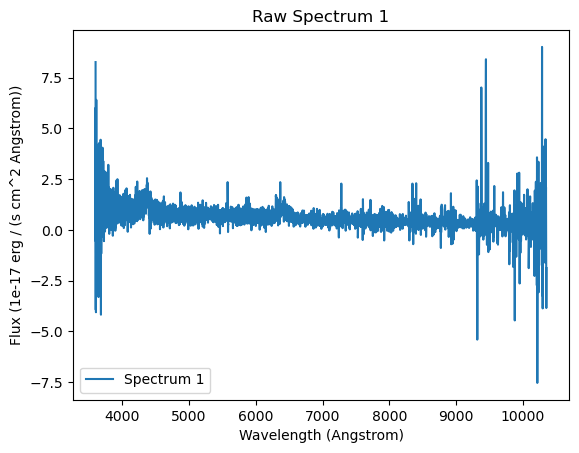

Loaded spectrum 2 from ../data/spectra/sell_2_QSO_2.fits:
  Wavelength range: 3794.0224609375 Angstrom - 9193.9052734375 Angstrom


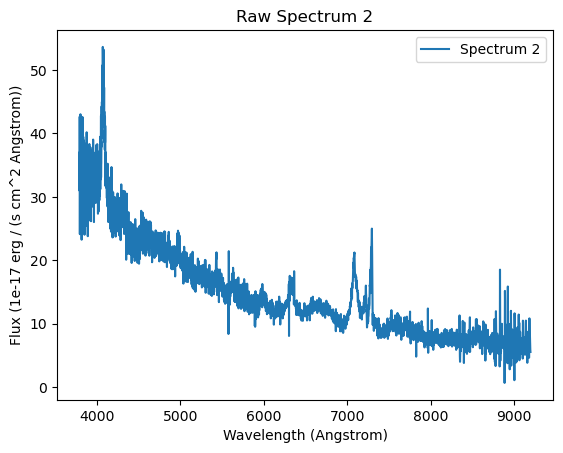

In [9]:
 def load_and_plot_spectra(filepaths):
    spectra = []

    for i, filepath in enumerate(filepaths, start=1):
        try:
            hdulist = fits.open(filepath)
            flux = hdulist[1].data['flux'] * u.Unit('1e-17 erg / (s cm^2 Angstrom)')
            wavelength = 10**hdulist[1].data['loglam'] * u.Angstrom
            spectrum = Spectrum1D(flux=flux, spectral_axis=wavelength)

            spectra.append(spectrum)

            print(f"Loaded spectrum {i} from {filepath}:")
            print(f"  Wavelength range: {wavelength.min()} - {wavelength.max()}")

            plt.figure()
            plt.plot(wavelength, flux, label=f"Spectrum {i}")
            plt.xlabel('Wavelength (Angstrom)')
            plt.ylabel('Flux (1e-17 erg / (s cm^2 Angstrom))')
            plt.title(f'Raw Spectrum {i}')
            plt.legend()
            plt.show()

        except Exception as e:
            print(f"Error loading spectrum {i} from {filepath}: {e}")

    return spectra

filepaths = [
    "../data/spectra/sell_2_QSO_1.fits",
    "../data/spectra/sell_2_QSO_2.fits"
]
spectra = load_and_plot_spectra(filepaths)


Normalized spectrum 1 from ../data/spectra/sell_2_QSO_1.fits:
  Wavelength range: 3599.978759765625 Angstrom - 10351.4189453125 Angstrom


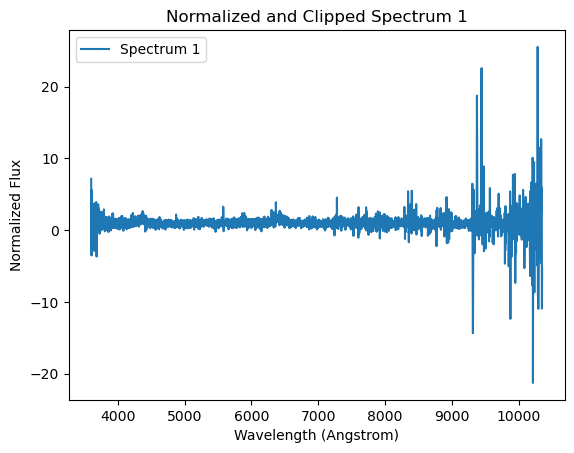

Normalized spectrum 2 from ../data/spectra/sell_2_QSO_2.fits:
  Wavelength range: 3794.0224609375 Angstrom - 9193.9052734375 Angstrom


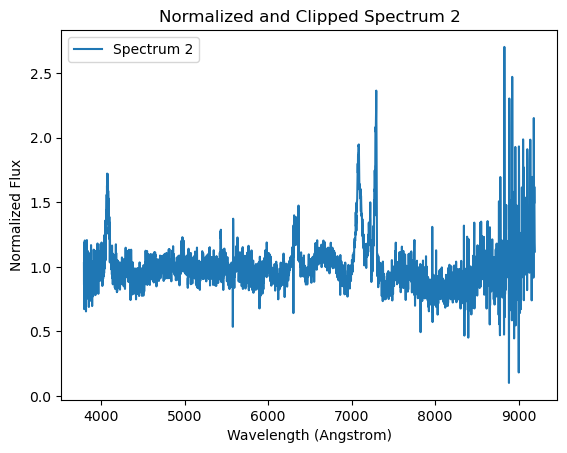

In [10]:
def load_and_normalize_spectra(filepaths, clip_value=60):
    normalized_spectra = []

    for i, filepath in enumerate(filepaths, start=1):
        try:
            hdulist = fits.open(filepath)
            flux = hdulist[1].data['flux'] * u.Unit('1e-17 erg / (s cm^2 Angstrom)')
            wavelength = 10**hdulist[1].data['loglam'] * u.Angstrom
            spectrum = Spectrum1D(flux=flux, spectral_axis=wavelength)

            polynomial_model = models.Polynomial1D(degree=3)
            continuum_fit = fit_continuum(spectrum, model=polynomial_model)
            normalized_spectrum = spectrum / continuum_fit(spectrum.spectral_axis)

            clipped_flux = np.clip(normalized_spectrum.flux, a_min=-clip_value, a_max=clip_value)
            clipped_normalized_spectrum = Spectrum1D(flux=clipped_flux, spectral_axis=wavelength)

            normalized_spectra.append(clipped_normalized_spectrum)

            print(f"Normalized spectrum {i} from {filepath}:")
            print(f"  Wavelength range: {wavelength.min()} - {wavelength.max()}")

            plt.figure()
            plt.plot(wavelength, clipped_flux, label=f'Spectrum {i}')
            plt.xlabel('Wavelength (Angstrom)')
            plt.ylabel('Normalized Flux')
            plt.title(f'Normalized and Clipped Spectrum {i}')
            plt.legend()
            plt.show()

        except Exception as e:
            print(f"Error normalizing spectrum {i} from {filepath}: {e}")

    return normalized_spectra

filepaths = [
    "../data/spectra/sell_2_QSO_1.fits",
    "../data/spectra/sell_2_QSO_2.fits"
]
normalized_spectra = load_and_normalize_spectra(filepaths)



--- QSO Spectrum 1 ---
Expected wavelength for Mg II 2796 Å line: 3919.62 Angstrom
Expected wavelength for Mg II 2803 Å line: 3929.43 Angstrom


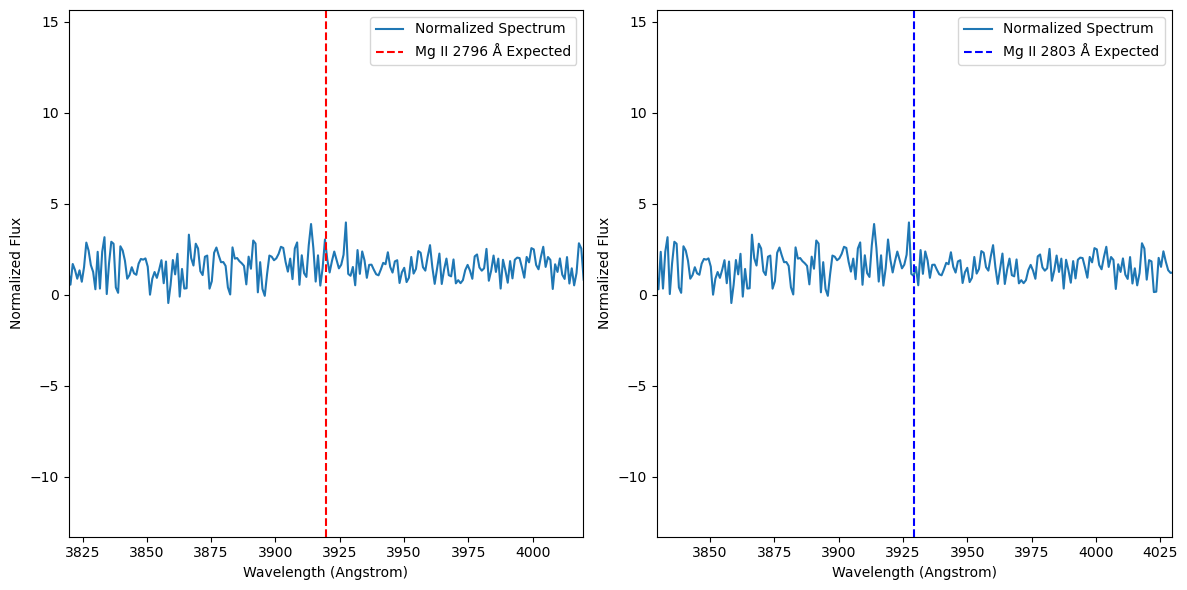


--- QSO Spectrum 2 ---
Expected wavelength for Mg II 2796 Å line: 3919.62 Angstrom
Expected wavelength for Mg II 2803 Å line: 3929.43 Angstrom


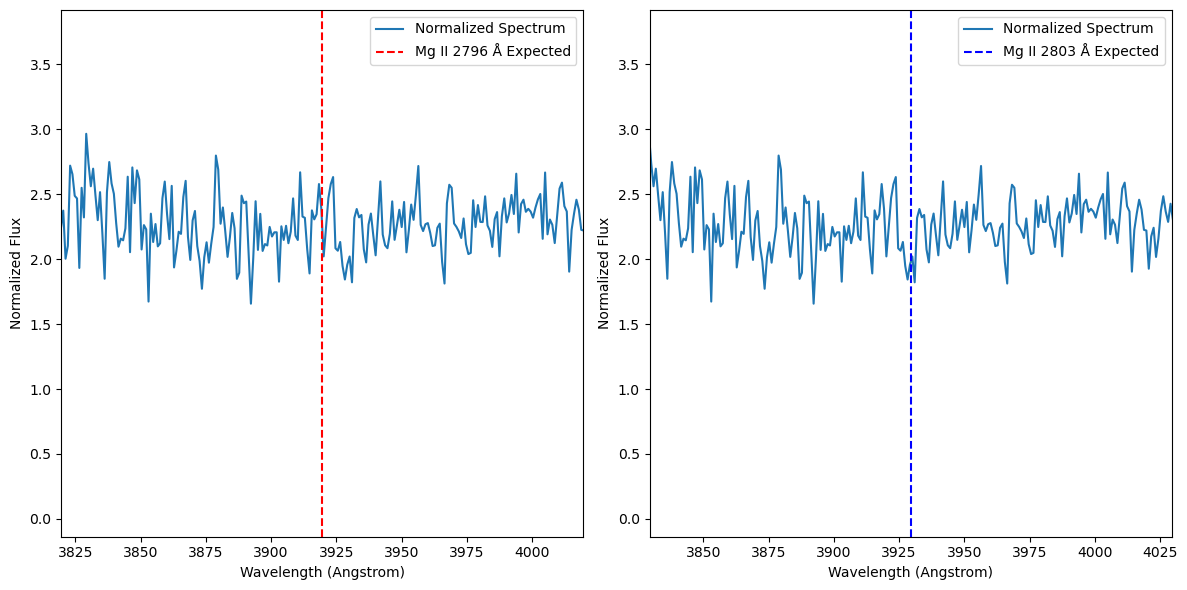

In [11]:
def plot_mgii_doublet(wavelength, normalized_spectrum, redshift):
    mgii_2796_expected = 2796 * u.Angstrom * (1 + redshift)
    mgii_2803_expected = 2803 * u.Angstrom * (1 + redshift)

    print(f"Expected wavelength for Mg II 2796 Å line: {mgii_2796_expected:.2f}")
    print(f"Expected wavelength for Mg II 2803 Å line: {mgii_2803_expected:.2f}")

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(wavelength, normalized_spectrum.flux, label='Normalized Spectrum')
    plt.axvline(x=mgii_2796_expected.value, color='r', linestyle='--', label='Mg II 2796 Å Expected')
    plt.xlim(mgii_2796_expected.value - 100, mgii_2796_expected.value + 100)
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Normalized Flux')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(wavelength, normalized_spectrum.flux, label='Normalized Spectrum')
    plt.axvline(x=mgii_2803_expected.value, color='b', linestyle='--', label='Mg II 2803 Å Expected')
    plt.xlim(mgii_2803_expected.value - 100, mgii_2803_expected.value + 100)
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Normalized Flux')
    plt.legend()

    plt.tight_layout()
    plt.show()


filepaths = [
    "../data/spectra/sell_2_QSO_1.fits",
    "../data/spectra/sell_2_QSO_2.fits"
]
for i, filepath in enumerate(filepaths, start=1):
    hdulist = fits.open(filepath)
    flux = hdulist[1].data['flux'] * u.Unit('1e-17 erg / (s cm^2 Angstrom)')
    wavelength = 10**hdulist[1].data['loglam'] * u.Angstrom

    normalized_flux = flux / np.median(flux)
    normalized_spectrum = Spectrum1D(flux=normalized_flux, spectral_axis=wavelength)

    print(f"\n--- QSO Spectrum {i} ---")
    plot_mgii_doublet(wavelength, normalized_spectrum, redshift)


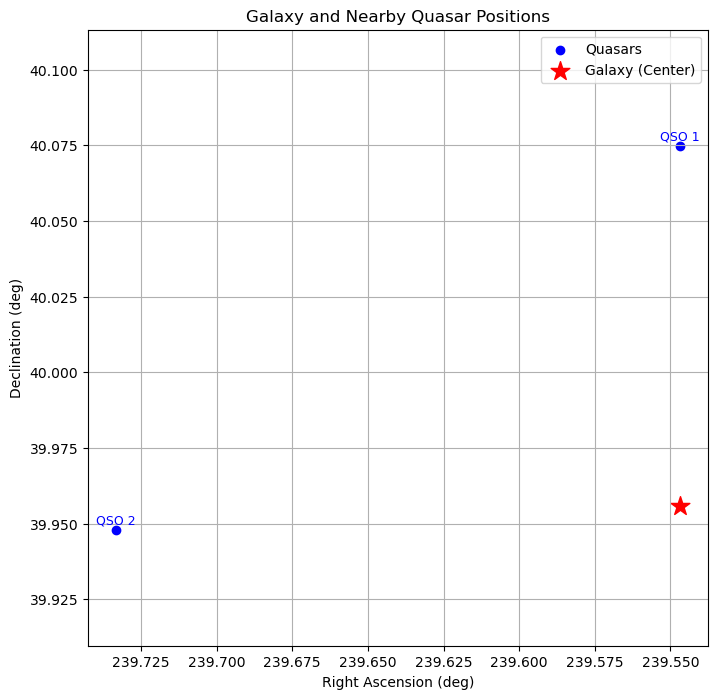

In [12]:
galaxy_ra = ra 
galaxy_dec = dec

quasar_ra_list = ra_list
quasar_dec_list = dec_list

plt.figure(figsize=(8, 8))
plt.scatter(ra_list, dec_list, color='blue', label='Quasars')
plt.scatter(ra, dec, color='red', marker='*', s=200, label='Galaxy (Center)')

for i, (ra, dec) in enumerate(zip(ra_list, dec_list), start=1):
    plt.text(ra, dec + 0.002, f"QSO {i}", color='blue', ha='center', fontsize=9)

plt.xlabel("Right Ascension (deg)")
plt.ylabel("Declination (deg)")
plt.title("Galaxy and Nearby Quasar Positions")
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()  
plt.axis('equal')
plt.show()

In [13]:
D_A = cosmo.angular_diameter_distance(redshift)

galaxy_coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')

print(f"\nGalaxy redshift: z = {redshift}")
print(f"Angular diameter distance: {D_A:.2f}")

for i, (ra, dec) in enumerate(zip(quasar_ra_list, quasar_dec_list), start=1):
    quasar_coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')
    angular_sep = galaxy_coord.separation(quasar_coord)
    physical_sep = (angular_sep.radian * D_A).to(u.kpc)

    print(f"\nQSO {i}:")
    print(f"  Angular separation: {angular_sep.arcmin:.2f} arcmin")
    print(f"  Projected distance: {physical_sep:.2f}")


Galaxy redshift: z = 0.4018661
Angular diameter distance: 1146.17 Mpc

QSO 1:
  Angular separation: 11.45 arcmin
  Projected distance: 3819.17 kpc

QSO 2:
  Angular separation: 0.00 arcmin
  Projected distance: 0.00 kpc


In [14]:
galaxy_coord = SkyCoord(ra=galaxy_ra * u.deg, dec=galaxy_dec * u.deg, frame='icrs')

print("Angular separation between galaxy and each quasar:")
for i, (ra, dec) in enumerate(zip(quasar_ra_list, quasar_dec_list), start=1):
    qso_coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')
    sep = galaxy_coord.separation(qso_coord)
    print(f"QSO {i}: {sep.arcmin:.2f}")

Angular separation between galaxy and each quasar:
QSO 1: 7.15
QSO 2: 8.58


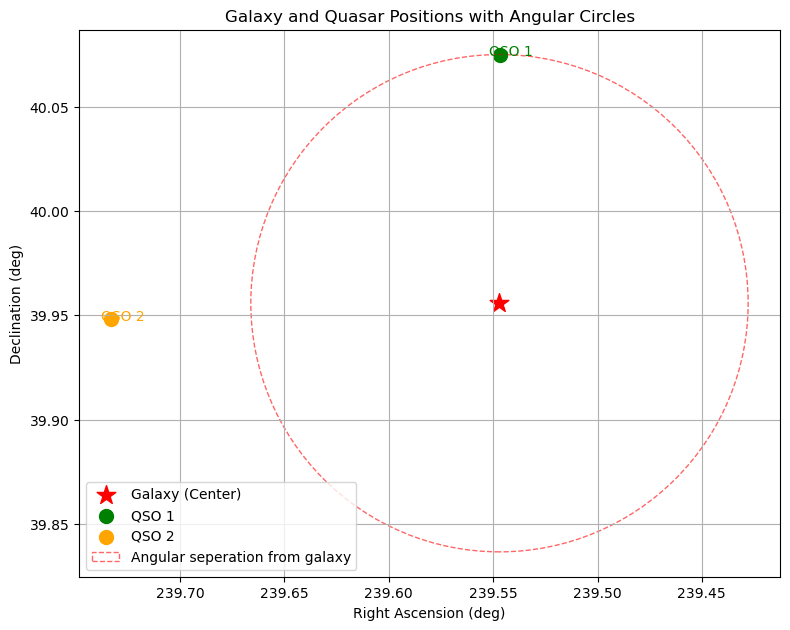

In [15]:
qso_colors = ['green', 'orange']

circle_arcmins = [7.15] 
circle_labels = ['Angular seperation from galaxy']
circle_colors = ['red']

# Convert arcmin to degrees
circle_radii_deg = [r / 60.0 for r in circle_arcmins]

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(galaxy_ra, galaxy_dec, color='red', marker='*', s=200, label='Galaxy (Center)')

for i, (ra, dec, color) in enumerate(zip(quasar_ra_list, quasar_dec_list, qso_colors), start=1):
    ax.scatter(ra, dec, color=color, s=100, label=f"QSO {i}")
    ax.text(ra + 0.005, dec, f"QSO {i}", color=color, fontsize=10)

for radius_deg, label, circle_color in zip(circle_radii_deg, circle_labels, circle_colors):
    circle = plt.Circle((galaxy_ra, galaxy_dec), radius_deg, color=circle_color, fill=False,
                        linestyle='--', alpha=0.6, label=label)
    ax.add_patch(circle)

ax.set_xlabel("Right Ascension (deg)")
ax.set_ylabel("Declination (deg)")
ax.set_title("Galaxy and Quasar Positions with Angular Circles")
ax.set_aspect('equal')
ax.grid(True)
ax.invert_xaxis()
ax.legend(loc='lower left')
plt.tight_layout()
plt.show()